In [1]:
# Install required packages
!pip install ultralytics roboflow opencv-python matplotlib seaborn tqdm -q

# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from tqdm import tqdm
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Check if Ultralytics is available
try:
    from ultralytics import YOLO
    print("Ultralytics YOLO installed successfully!")
except ImportError:
    print("Installing Ultralytics...")
    !pip install ultralytics -q
    from ultralytics import YOLO

Ultralytics YOLO installed successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Exploration and Analysis

In [3]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/Detection /Dataset "
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")


In [4]:
# Function to count files in each directory
def count_files(directory):
    image_dir = os.path.join(directory, "images")
    label_dir = os.path.join(directory, "labels")

    if os.path.exists(image_dir) and os.path.exists(label_dir):
        image_count = len([name for name in os.listdir(image_dir) if name.endswith(('.jpg', '.jpeg', '.png'))])
        label_count = len([name for name in os.listdir(label_dir) if name.endswith('.txt')])
        return image_count, label_count
    return 0, 0

# Count files in each dataset split
train_images, train_labels = count_files(train_path)
val_images, val_labels = count_files(val_path)
test_images, test_labels = count_files(test_path)

print(" Dataset Statistics:")
print(f" Training set: {train_images} images, {train_labels} labels")
print(f" Validation set: {val_images} images, {val_labels} labels")
print(f" Test set: {test_images} images, {test_labels} labels")

# Check for any mismatches
if train_images != train_labels or val_images != val_labels or test_images != test_labels:
    print(" Warning: Some images might not have corresponding labels or vice versa")
else:
    print(" All images have corresponding labels")

 Dataset Statistics:
 Training set: 1273 images, 1273 labels
 Validation set: 363 images, 363 labels
 Test set: 182 images, 182 labels
 All images have corresponding labels


# Understanding the Label Format

In [5]:
# Function to parse a label file
def parse_label_file(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:
        data = line.strip().split()
        if len(data) == 5:  # YOLO format: class_id, x_center, y_center, width, height
            class_id, x_center, y_center, width, height = map(float, data)
            annotations.append({
                'class_id': int(class_id),
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
    return annotations

# Check a sample label file
sample_label_path = os.path.join(train_path, "labels", os.listdir(os.path.join(train_path, "labels"))[0])
sample_annotations = parse_label_file(sample_label_path)
print(" Sample label file contents:")
for ann in sample_annotations:
    print(f"  Class ID: {ann['class_id']}, Center: ({ann['x_center']:.3f}, {ann['y_center']:.3f}), Size: ({ann['width']:.3f}, {ann['height']:.3f})")

 Sample label file contents:
  Class ID: 0, Center: (0.396, 0.651), Size: (0.377, 0.095)


# Visualizing Sample Images with Bounding Boxes

 Training set samples:


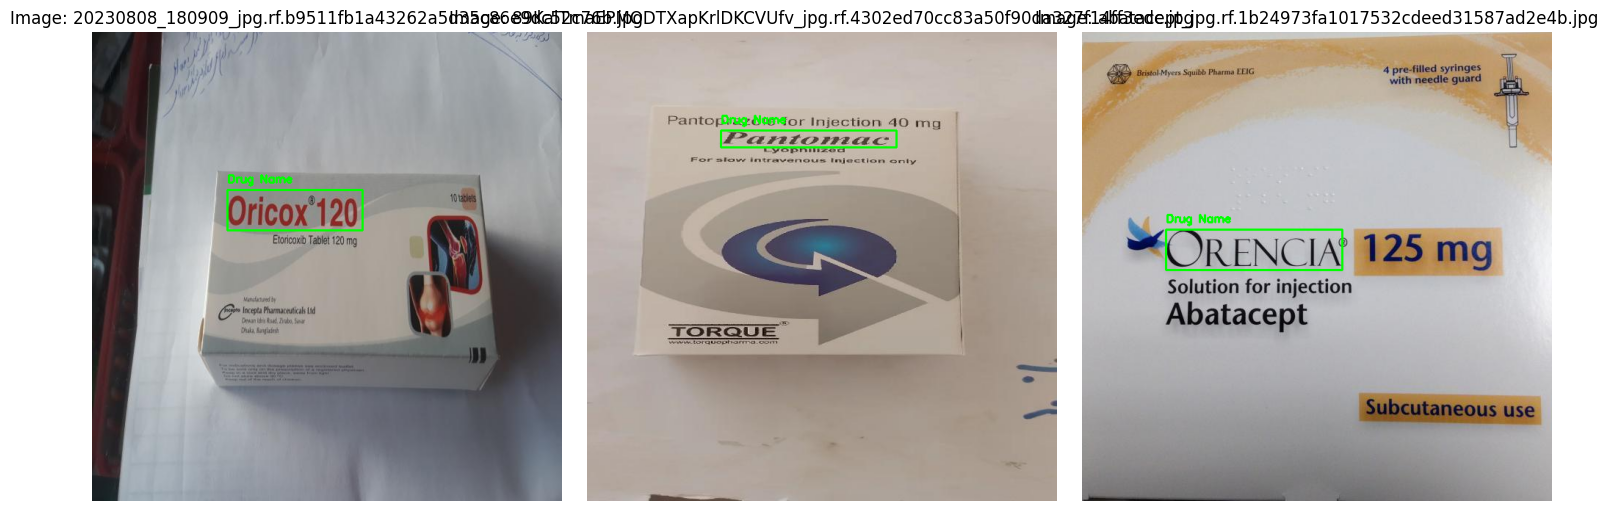

In [6]:
# Function to convert YOLO format to pixel coordinates
def yolo_to_pixels(x_center, y_center, width, height, img_width, img_height):
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    return x_min, y_min, x_max, y_max

# Function to visualize images with bounding boxes
def visualize_sample(image_dir, label_dir, num_samples=3):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i, img_file in enumerate(selected_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image.shape[:2]

        # Load corresponding label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)

        if os.path.exists(label_path):
            annotations = parse_label_file(label_path)

            # Draw bounding boxes
            for ann in annotations:
                x_min, y_min, x_max, y_max = yolo_to_pixels(
                    ann['x_center'], ann['y_center'],
                    ann['width'], ann['height'],
                    img_width, img_height
                )

                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(image, f"Drug Name", (x_min, y_min-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Image: {img_file}")

    plt.tight_layout()
    plt.show()

# Visualize samples from training set
train_image_dir = os.path.join(train_path, "images")
train_label_dir = os.path.join(train_path, "labels")
print(" Training set samples:")
visualize_sample(train_image_dir, train_label_dir)

# Data Preparation and Augmentation
prepare our data for training with proper preprocessing and augmentation.

In [7]:
# Create dataset.yaml configuration file
dataset_config = {
    'path': dataset_path,
    'train': 'train',
    'val': 'valid',
    'test': 'test',
    'names': {0: 'drug_name'},
    'nc': 1  # number of classes
}

# Save the configuration file
with open('dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(" Dataset configuration file created successfully!")
print(" Configuration content:")
print(yaml.dump(dataset_config, default_flow_style=False))

 Dataset configuration file created successfully!
 Configuration content:
names:
  0: drug_name
nc: 1
path: '/content/drive/MyDrive/Detection /Dataset '
test: test
train: train
val: valid



# Initialize YOLO Model

In [8]:
# Initialize YOLO model
model = YOLO('yolov8n.pt')  # Using YOLOv8 nano version for faster training

print(" YOLO model initialized successfully!")
print(f" Model architecture: YOLOv8n")
print(f" Number of classes: {dataset_config['nc']}")
print(f" Class names: {dataset_config['names']}")

 YOLO model initialized successfully!
 Model architecture: YOLOv8n
 Number of classes: 1
 Class names: {0: 'drug_name'}


# Train the YOLO Model

In [9]:

print("Starting YOLOv8 training for drug name detection...")

# Training parameters
training_params = {
    "data": "dataset.yaml",
    "epochs": 100,
    "imgsz": 640,
    "batch": 8,
    "name": "drug_name_detection",
    "patience": 10,
    "save": True,
    "save_period": 10,
    "optimizer": "Adam",
    "lr0": 0.001,
    "weight_decay": 0.0005,
}
# Start training
results = model.train(**training_params)

print(" Training completed successfully!")
print("Best model saved at: runs/detect/drug_name_detection/weights/best.pt")

Starting YOLOv8 training for drug name detection...
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=drug_name_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=Tru

# Evaluate the Trained Model

In [10]:
# Evaluate the model
print(" Evaluating model performance...")

# Load the best model from training
best_model_path = os.path.join('runs', 'detect', 'drug_name_detection', 'weights', 'best.pt')
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    print(" Loaded best model from training")
else:
    print("Best model not found, using last trained model")

# Evaluate on test set
metrics = model.val(
    data='dataset.yaml',
    split='test',
    imgsz=640,
    batch=8,
    device='cpu'  # Change to 'cuda' if GPU is available
)

print(" Evaluation Results:")
print(f"   mAP50: {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall: {metrics.box.mr:.4f}")

 Evaluating model performance...
Best model not found, using last trained model
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 2.1±2.5 ms, read: 3.7±7.9 MB/s, size: 30.2 KB)
val: Scanning /content/drive/MyDrive/Detection /Dataset /test/labels... 182 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 182/182 3.3it/s 55.2s
val: New cache created: /content/drive/MyDrive/Detection /Dataset /test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 35, len(boxes) = 182. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 0.6it/s 41.1s
                   all        182        

# Visualize Predictions on Test Images

 Visualizing predictions on test images:
Best model not found, using the current model for visualization



RuntimeError: Inference tensors do not track version counter.

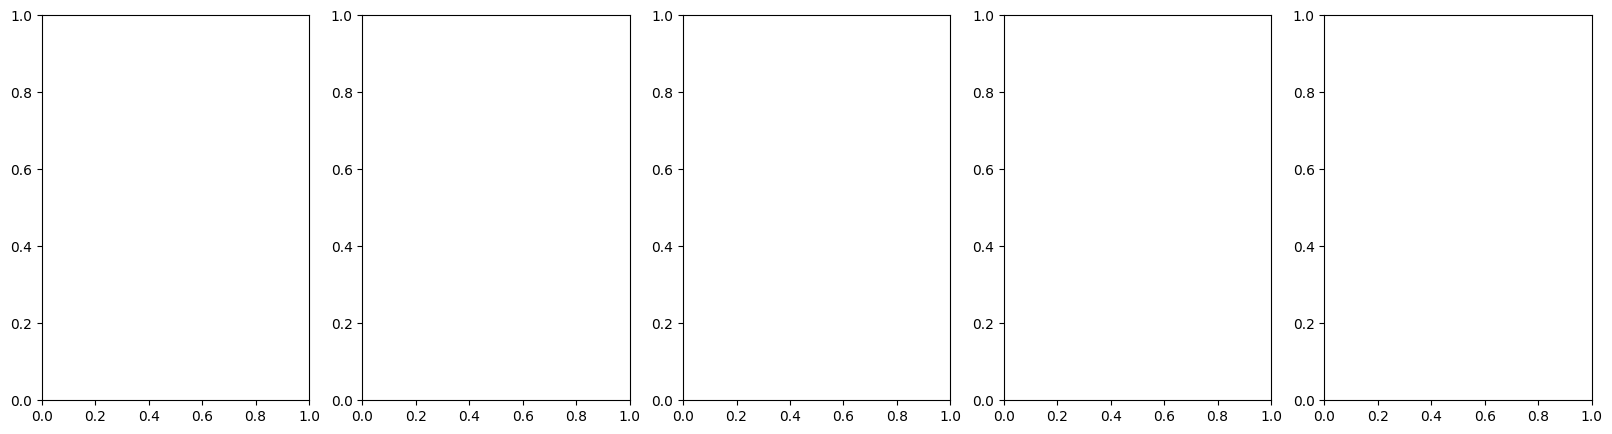

In [14]:
# Function to visualize predictions
def visualize_predictions(model, image_dir, num_samples=5):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    if num_samples == 1:
        axes = [axes]

    # Load the best model if it exists
    best_model_path = os.path.join('runs', 'detect', 'drug_name_detection', 'weights', 'best.pt')
    if os.path.exists(best_model_path):
        model = YOLO(best_model_path)
        print(" Loaded best model for visualization")
    else:
        print("Best model not found, using the current model for visualization")

    # Set model to evaluation mode and disable gradient tracking
    model.eval()
    import torch
    with torch.no_grad():
      for i, img_file in enumerate(selected_files):
          # Load image
          img_path = os.path.join(image_dir, img_file)

          # Run prediction
          results = model(img_path, conf=0.5)

          # Plot results
          plotted_img = results[0].plot()
          plotted_img = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

          axes[i].imshow(plotted_img)
          axes[i].axis('off')
          axes[i].set_title(f"Prediction: {img_file}")

    plt.tight_layout()
    plt.show()

# Visualize predictions on test images
test_image_dir = os.path.join(test_path, "images")
print(" Visualizing predictions on test images:")
visualize_predictions(model, test_image_dir)

# Export Model for Deployment

In [ ]:
# Export model to different formats
print(" Exporting model for deployment...")

# Export to ONNX format
onnx_path = model.export(format='onnx')
print(f" Model exported to ONNX format: {onnx_path}")

# Export to TensorRT format (if GPU available)
try:
    trt_path = model.export(format='engine')
    print(f" Model exported to TensorRT format: {trt_path}")
except Exception as e:
    print(f" TensorRT export failed: {e}")

# Export to TFLite format
try:
    tflite_path = model.export(format='tflite')
    print(f" Model exported to TFLite format: {tflite_path}")
except Exception as e:
    print(f" TFLite export failed: {e}")

print(" All export operations completed!")

# Create Inference Function

In [ ]:
# Function for inference on new images
def detect_drug_name(image_path, model_path=None, confidence=0.5):
    """
    Detect drug name on medication package

    Args:
        image_path (str): Path to the image file
        model_path (str): Path to the trained model (uses best model if None)
        confidence (float): Confidence threshold for detection

    Returns:
        results: YOLO results object
        image: Image with bounding boxes drawn
    """
    # Load model if path is provided
    if model_path is not None and os.path.exists(model_path):
        inference_model = YOLO(model_path)
    else:
        inference_model = model

    # Run inference
    results = inference_model(image_path, conf=confidence)

    # Extract results
    boxes = results[0].boxes
    image_with_boxes = results[0].plot()
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    # Print detection summary
    print(f"🔍 Detected {len(boxes)} drug name(s) in the image")
    for i, box in enumerate(boxes):
        print(f"   Detection {i+1}: Confidence = {box.conf.item():.3f}")

    return results, image_with_boxes

# Test the inference function
sample_test_image = os.path.join(test_path, "images", os.listdir(test_image_dir)[0])
print(" Testing inference function:")
results, output_image = detect_drug_name(sample_test_image)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(output_image)
plt.axis('off')
plt.title("Drug Name Detection Result")
plt.show()